In [13]:
from folktables import ACSDataSource, ACSPublicCoverage, ACSIncome, ACSHealthInsurance
from sklearn.linear_model import LogisticRegression
from itertools import permutations
from folktables import ACSDataSource, ACSEmployment
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [70]:
def wealth_process(seq, alpha=0.05, extend=True, stop=False): 
    # Construct wealth process from sequence X using ONS 
    
    wealth = 1
    wealth_hist = [1] 
    const = 2 / (2 - np.log(3))
    lambd = 0 
    zt2 = 0 
    for t in range(1,len(seq)): 
                
        St = 1 - lambd*seq[t]
        wealth = wealth * St 
        wealth_hist.append(wealth)
        if wealth > 1/alpha: 
            #print(f"Reject at time {t}")
            break 
        
        # Update lambda via ONS  
        z = seq[t] / (1 - lambd*seq[t])
        zt2 += z**2
        lambd = max(min(lambd - const*z/(1 + zt2), 1/2), -1/2)
        
    if extend: 
        if len(wealth_hist) < len(seq): 
            buffer = [wealth]*(len(seq)-len(wealth_hist))
            wealth_hist.extend(buffer)
            assert len(wealth_hist) == len(seq), print(len(seq), len(wealth_hist))

        
    return wealth_hist
           

In [83]:
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

y_hat_1 = []
y_hat_2 = []
data_source = ACSDataSource(survey_year=2014, horizon='1-Year', survey='person')
acs_data14 = data_source.get_data(states=["PA"], download=True)
features14, labels14, _ = ACSHealthInsurance.df_to_numpy(acs_data14)

# Train model on 2014 data
# Plug-in your method for tabular datasets
model = LogisticRegression()
model.fit(features14, labels14)

LogisticRegression()

In [113]:
good_states = []
for state in state_list :
    print(state)
    data_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=False)
    features, labels, group = ACSHealthInsurance.df_to_numpy(acs_data)
    y_1 = model.predict(features[(features[:,1] == 21)*(labels == 1)])
    y_2 = model.predict(features[(features[:,1] != 21)*(labels == 1)])
    print(np.mean(y_1),np.mean(y_2))
    if np.mean(y_1) > np.mean(y_2):
        good_states.append(state)

AL
0.9864209505334627 0.9699436443331246
AK
0.9876543209876543 0.8982630272952854
AZ
0.976931330472103 0.8694747153177421
AR
0.9481361426256077 0.8586400194979283
CA
0.8602921408728381 0.7220025403216143
CO
0.8026249369005553 0.7103733170134638
CT
0.7670837343599615 0.7068965517241379
DE
0.8771929824561403 0.7808939526730938
FL
0.7537878787878788 0.7064067593639811
GA
0.6795288383428107 0.6835238009538378
HI
0.6857142857142857 0.6527958387516255
ID
0.5942307692307692 0.6425881547415269
IL
0.5732180137190576 0.6629322626602772
IN
0.5659955257270693 0.6740279572418654
IA
0.6427672955974842 0.7143387126692636
KS
0.5845464725643897 0.6418201516793066
KY
0.5360576923076923 0.6416981132075472
LA
0.4492600422832981 0.5557296767874633
ME
0.5284090909090909 0.5985772357723578
MD
0.396356783919598 0.45617977528089887
MA
0.33692596063730085 0.4333215838326871
MI
0.39915174363807726 0.5003965736040609
MN
0.43591191417278374 0.5154111494380772
MS
0.30045523520485584 0.3833960236432026
MO
0.21267297

In [99]:
accuracies = []
data_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CO"], download=True)
features, labels, group = ACSHealthInsurance.df_to_numpy(acs_data)
y_1 = model.predict(features[(features[:,1] == 21)*(labels == 1)])
y_2 = model.predict(features[(features[:,1] != 21)*(labels == 1)])
wealth_arr=[]
for i in range(100):
    y_hat_1 = []
    y_hat_2 = []
    values = []
    for i in range(1500):
        observation_1 = np.random.choice(y_1, 1)
        observation_2 = np.random.choice(y_2, 1)
#         import pdb; pdb.set_trace()
        values.append(int(observation_2) - int(observation_1))
    wealth = wealth_process(values)
    wealth_arr.append(wealth)

In [100]:
def plot_wealth(arr, label, c, size): 
    
    mean = np.mean(arr, axis=0)   
    std = np.std(arr, axis=0)
    plt.plot(range(size), mean, label=label, c=c)
    plt.fill_between(range(len(mean)), mean+std, mean-std, alpha=0.1, color=c)
    

In [103]:
size = len(wealth_arr[0])

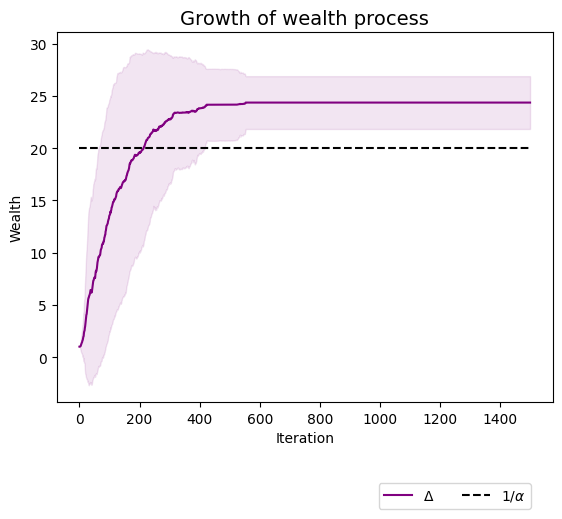

In [126]:
plot_wealth(wealth_arr, label='$\Delta$', c='purple', size=size)
plt.hlines(1/0.05, 0, size, ls='--', color='k', label='$1/\\alpha$')

plt.title('Growth of wealth process', fontsize=14)
# plt.ylim(-10, 150)
plt.ylabel('Wealth')
plt.xlabel('Iteration')
plt.legend(bbox_to_anchor=(0.97,-0.2), ncol=3)

plt.savefig('wealth_proc_rc.png', dpi=300, bbox_inches='tight')

### Simulate distirbution shift

By state

In [118]:
good_states
accuracies = []
ys = {}
for state in good_states:
    data_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=False)
    features, labels, group = ACSHealthInsurance.df_to_numpy(acs_data)
    y_1 = model.predict(features[(features[:,1] == 21)*(labels == 1)])
    y_2 = model.predict(features[(features[:,1] != 21)*(labels == 1)])
    ys[state] = (y_1, y_2)
wealth_arr=[]
for i in range(100):
    y_hat_1 = []
    y_hat_2 = []
    values = []
    for i in range(1500):
            state = good_states[i % len(good_states)]
            y_1, y_2 = ys[state]
            observation_1 = np.random.choice(y_1, 1)
            observation_2 = np.random.choice(y_2, 1)
#         import pdb; pdb.set_trace()
            values.append(int(observation_2) - int(observation_1))
    wealth = wealth_process(values)
    wealth_arr.append(wealth)

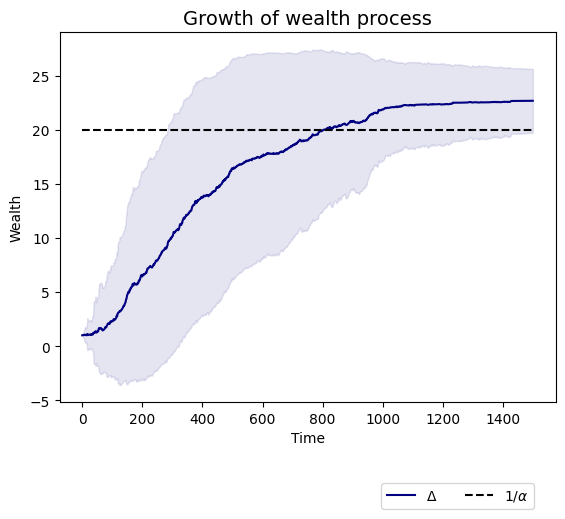

In [119]:
plot_wealth(wealth_arr, label='$\Delta$', c='navy', size=size)
plt.hlines(1/0.05, 0, size, ls='--', color='k', label='$1/\\alpha$')

plt.title('Growth of wealth process', fontsize=14)
# plt.ylim(-10, 150)
plt.ylabel('Wealth')
plt.xlabel('Iteration')
plt.legend(bbox_to_anchor=(0.97,-0.2), ncol=3)

plt.savefig('wealth_proc_rc.png', dpi=300, bbox_inches='tight')

By time

In [124]:
good_states
accuracies = []
ys = {}
years = [2015, 2016, 2017, 2018, 2019]
for year in years:
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=False)
    features, labels, group = ACSHealthInsurance.df_to_numpy(acs_data)
    y_1 = model.predict(features[(features[:,1] == 21)*(labels == 1)])
    y_2 = model.predict(features[(features[:,1] != 21)*(labels == 1)])
    ys[year] = (y_1, y_2)
wealth_arr=[]
for i in range(100):
    y_hat_1 = []
    y_hat_2 = []
    values = []
    for i in range(1500):
            year = years[i % len(years)]
            y_1, y_2 = ys[year]
            observation_1 = np.random.choice(y_1, 1)
            observation_2 = np.random.choice(y_2, 1)
#         import pdb; pdb.set_trace()
            values.append(int(observation_2) - int(observation_1))
    wealth = wealth_process(values)
    wealth_arr.append(wealth)

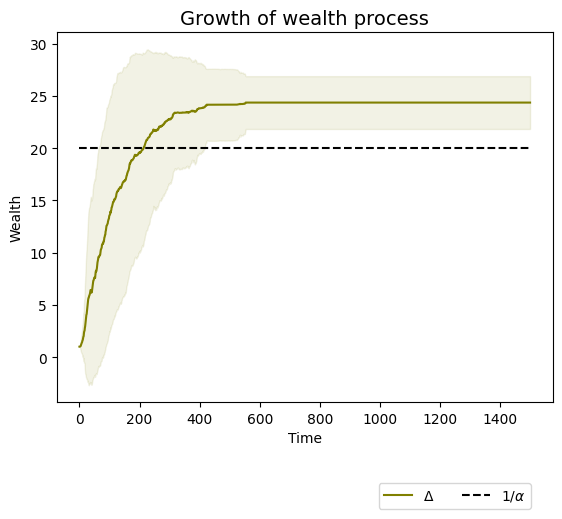

In [125]:
plot_wealth(wealth_arr, label='$\Delta$', c='olive', size=size)
plt.hlines(1/0.05, 0, size, ls='--', color='k', label='$1/\\alpha$')

plt.title('Growth of wealth process', fontsize=14)
# plt.ylim(-10, 150)
plt.ylabel('Wealth')
plt.xlabel('Iteration')
plt.legend(bbox_to_anchor=(0.97,-0.2), ncol=3)

plt.savefig('wealth_proc_rc.png', dpi=300, bbox_inches='tight')